## GEM workshop
### Satellite pre-processing as input for the meteoblue city climate model (MCCM)

In this notebook we show how the meteoblue satellite pre-processing works. Satellite-derived surface properties are needed as input field for the high-resolution model of meteoblue which allows to resolve air temperatures in urban areas with a horizontal resolution of 10 meters.

**What are we doing?** </p>
We are going to produce a satellite dataset step-by-step for the urban area of **Chicago, USA**.

**Data basis** </p>
For the satellite processing, we need data from the polar-orbiting satellites **Sentinel-2** (ESA) and **Landsat 8** (NASA/USGS).
The data can be found under the following links:
- Sentinel-2: Copernicus Open Access Hub (https://scihub.copernicus.eu/dhus/#/home)
- Landsat 8: USGS Earth Explorer (https://earthexplorer.usgs.gov/)

You will find the zipped data *S2A_...* (Sentinel-2) and *LC09...* (Landsat 8) for this workshop notebook in the Sinergise cloud under the following link (...). </p>
**Do not unzip the data. This will be done during the processing.**

For the satellite processing it is **important** that
- the sensing date of the satellite scenes are in the summer of the respective hemisphere
- the satellite scene is cloud-free in the area of interest.

**Derived satellite properties** </p>
We derive several satellite properties which are providing information about the surface structure within urban areas. These properties are the main predictors within the MCCM model and enable to resolve the small-scale air temperature variability.

We derive the following satellite properties from Sentinel-2:
- NDVI (Normalized Difference Vegetation Index)
- NDBI (Normalized Difference Build-up Index)
- NDWI (Normalized Difference Water Index)
- Albedo

Landsat 8:
- LST (Land surface temperature)

**Output** </p>
The output file will be in a netCDF format which includes the five different surface properties as 2-dimensional field and the spatial information which will be given in geographic coordinates (WGS84) with latitude and longitude.

In [2]:
import pandas as pd
import numpy as np
import zipfile
import tarfile
import glob
import xmltodict
import utm
import rasterio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import netCDF4 as nc

from functions.landsat8_utils import *
from functions.sentinel2_utils import *
from functions.netcdf import *

#### Define input
You have to define the following input information:
- **Name of the city**/urban area ("*city*")
- The **bounding box** for your area of interest ("*bbox_wgs84*") in the following format:
(lon_min, lat_min, lon_max, lat_max)
- Path to the zipped **Sentinel-2 data folder** ("*path_sentinel_zip*")
- Path to the zipped (.tar) **Landsat 8 data folder** ("*path_landsat*")

In [1]:
# Define the name of the City
city = "Chicago"

# Define bounding box (lon_min, lat_min, lon_max, lat_max)
bbox_wgs84 = [-88.12259, 41.50845, -87.37150, 42.10027]

# Path to zipped Sentinel images
path_sentinel_zip = "data/satellite/S2A_MSIL1C_20220614T163911_N0400_R126_T16TDM_20220614T203132.zip"

# Path to zipped Landsat images
path_landsat = "data/satellite/LC09_L1TP_023031_20220703_20220703_02_T1.tar"

#### Unzip the satellite data
The satellite gets unzipped and will be stored in a new folder with the same name.

New paths are defined to the new created folders:
- *path_sentinel*
- *path_landsat*

and to the image data:
- *jp2_path* (Sentinel-2 images)
- *tif_path* (Landsat 8 images)

In [3]:
# unzip the sentinel file into same directory
with zipfile.ZipFile(path_sentinel_zip,"r") as zip_ref:
    zip_ref.extractall(path_sentinel_zip.split(".zip")[0])

# untar the landsat file into same directory
with tarfile.open(path_landsat, "r") as tf:
    tf.extractall(path=path_landsat.split(".tar")[0])

## DEFINE NEW PATHS
# define new path to sentinel files
path_sentinel = path_sentinel_zip.split(".zip")[0] + \
                "/" + \
                path_sentinel_zip.split(".zip")[0].split("/")[len(path_sentinel_zip.split(".zip")[0].split("/"))-1] + ".SAFE"

# define new path to sentinel files
path_landsat = path_landsat.split(".tar")[0]

# get path to jp2 files (Sentinel)
jp2_path = glob.glob(glob.glob(path_sentinel+"/GRANULE/*")[0]+"/IMG_DATA/*")

# get the path to tif files (Landsat)
tif_path = glob.glob(path_landsat+"/*.TIF")

#### Sentinel-2 data processing
**I) Project the Sentinel-2 grid in the default map projection.** </p>
- Sentinel-2 images are projected in UTM (Universal Transverse Mercator) coordinates.
- Informations about the UTM-Zone and the spatial resolution of the satellite images are provided in the Metadata file which is located in */GRANULE/.../...MTD_TL.xml*
- Then, the grid is projected as 2-dimensional field in 10 x 10 m spatial resolution

**II) Reproject the UTM grid to a grid with geographic coordinates (longitude, latitude).** </p>
This projection is the basis for the satellite dataset at the end. </p>
After reprojecting the UTM grid to geographic coordinates, the grid's are shifted to each other and the new grid is not regular anymore.

In [4]:
# Get the Sentinel 2 projection for the big satellite scene
x_grid_big, y_grid_big, utm_zone_proj, utm_hemi_proj = sentinel2_proj(path_sentinel)

# Reproject the UTM grid to geographic coordinates
wgs84_coordinates = utm.to_latlon(x_grid_big[0,:], y_grid_big[:,0], int(utm_zone_proj), utm_hemi_proj)
lat_grid = wgs84_coordinates[0]
lon_grid = wgs84_coordinates[1]

Sentinel 2 grid projection
---------------------------


#### Sentinel-2 data processing
**III) Define a regular WGS84 grid for the scene of interest.** </p>
- Using the coordinates of the bounding box to define a regular grid in geographic coordinates.

In [7]:
# get scene of interest (bounding box) as regular WGS84 grid
# -> grid we want at the end
gridLAT, gridLON = bbox_grid_wgs84(lat_grid, lon_grid, bbox_wgs84)

Sentinel 2 define regular WGS84 grid
---------------------------


#### Sentinel-2 data processing
**IV) Clip the big satellite scene** </p>
- Clipping the big satellite scene to a smaller size for a faster computation time.
- Choose the clipped satellite scene by +/- 0.1º

In [8]:
# clip big satellite scene to bbox +/- 0.1º
# -> faster computation
x_grid_wgs84, y_grid_wgs84 = clip_satellite_scene(x_grid_big, y_grid_big, bbox_wgs84, utm_zone_proj, utm_hemi_proj)

Clipping big Satellite scene to smaller size
---------------------------


#### Sentinel-2 data processing
**V) Extract data of Sentinel-2 bands for the UTM grid**
- We extract the following Bands:
    - Band 2 - Blue (492.4 nm)
    - Band 3 - Green (559.8 nm)
    - Band 4 - Red (664.6 nm)
    - Band 8 - NIR (832.8 nm)
    - Band 11 - SWIR (1613.7 nm)
    - Band 12 - SWIR (2202.4 nm)
- for the UTM grid / not regular WGS84 grid

In [5]:
# Get array with clipped Sentinel 2 bands (Bands 2, 3, 4, 8, 11, 12)
# Grid is based on original UTM projection 
bands_array = sentinel2_bands(jp2_path, y_grid_big, x_grid_big, utm_zone_proj, bbox_wgs84)

Sentinel 2 bands extraction
Sentinel 2 bands clipping by bounding box
---------------------------


#### Sentinel-2 data processing
**VI) Sample bands with regular geographic coordinates**
- We extract the Bands with the regular geographic coordinates

In [20]:
# sample band data with regular WGS84 grid
bands_array, lon_grid_clip_sentinel, lat_grid_clip_sentinel = sample_with_regular_wgs84_grid(y_grid_wgs84, x_grid_wgs84, bands_array, gridLON, gridLAT)

Sentinel 2 sample by regular WGS84 grid
---------------------------


#### Sentinel-2 data processing
**VII) Calculate surface properties/model predictors**
- Processing the following surface properties from *bands_array*:
    - NDVI: (Band 8 - Band 4)/(Band 8 + Band 4) (source: ESRI)
    - NDBI: (Band 11 - Band 8)/(Band 11 + Band 8) (source: ESRI)
    - NDWI: (Band 3 - Band 8)/(Band 3 + Band 8) (source: ESRI)
    - Albedo: 0.356 * Band 2 + 0.130 * Band 4 + 0.373 * Band 8 + 0.085 * Band 11 + 0.072 * Band 12 - 0.0018 (source: Naegeli et al. (2017))

In [23]:
# Extract surface properties from Sentinel-2 data
ndvi, ndbi, ndwi, albedo = sentinel2_predictors(bands_array)

Sentinel 2 predictors calculation:
NDVI - DONE
NDBI - DONE
NDWI - DONE
Albedo - DONE
---------------------------


#### Landsat 8 data processing
**I) Project the Landsat 8 grid in the default map projection.** </p>
- Landsat 8 images are projected in UTM (Universal Transverse Mercator) coordinates.
- Informations about the UTM-Zone and the spatial resolution of the satellite images are provided in the Metadata file which is located in *...ANG.txt*
- Then, the grid is projected as 2-dimensional field in 30 x 30 m spatial resolution

**II) Reproject the UTM grid to a grid with geographic coordinates (longitude, latitude).** </p>
After reprojecting the UTM grid to geographic coordinates, the grid's are shifted to each other and the new grid is not regular anymore.

In [24]:
# get the Landsat 8 projection
x_grid_big, y_grid_big, utm_zone_proj = landsat8_proj(path_landsat)

# get latitude and longitude coordinates
print("Landsat 8 coordinates transformation:\nUTM "+str(utm_zone_proj)+str(utm_hemi_proj)+" -> geographic coordinates (WGS84)")
wgs84_coordinates = utm.to_latlon(x_grid_big[0,:], y_grid_big[:,0], int(utm_zone_proj), utm_hemi_proj)
lat_grid = wgs84_coordinates[0]
lon_grid = wgs84_coordinates[1]

Landsat 8 grid projection
---------------------------
Landsat 8 coordinates transformation:
UTM 35N -> geographic coordinates (WGS84)


#### Landsat 8 data processing
**III) Clip the big satellite scene** </p>
- Clipping the big satellite scene to a smaller size for a faster computation time.
- Choose the clipped satellite scene by +/- 0.1º

In [25]:
# clip big satellite scene to bbox +/- 0.1º
# -> faster computation
x_grid_wgs84, y_grid_wgs84 = clip_satellite_scene(x_grid_big, y_grid_big, bbox_wgs84, utm_zone_proj, utm_hemi_proj)

Clipping big Satellite scene to smaller size
---------------------------


#### Landsat 8 data processing
**IV) Extract data of Landsat 8 bands for the UTM grid**
- We extract the following Bands:
    - Band 10 - TIR (10.9 $\mu$m)
    - Band 11 - TIR (12.0 $\mu$m)
- for the UTM grid / not regular WGS84 grid

In [26]:
# get data of different satellite bands
# clip with bbox but +/- 0.1 degree to get all areas of sentinel 2 covered
bands_array = landsat8_bands(tif_path, y_grid_big, x_grid_big, utm_zone_proj, bbox_wgs84)

Landsat 8 bands extraction
Landsat 8 bands clipping to smaller size


#### Landsat 8 data processing
**V) Calculate surface properties/model predictors**
- Processing the LST from *bands_array*:
    - Calculate TOA radiance
    - Convert radiance to brightness temperature which is a measure of land surface temperature

In [27]:
# land surface temperatures
lst = landsat8_predictors(bands_array, path_landsat)

Landsat 8 predictors calculation:
LST - DONE
---------------------------


#### Landsat 8 data processing
**VI) Disaggregate Landsat 8 data**
- We want the LST in the same resolution as the Sentinel-2 data in 10 x 10 m
- Sample the LST data with the coordinates of Sentinel-2 by doing a cubic interpolation

In [33]:
# sample land surface temperature with regular WGS84 grid
lst = sample_lst_sentinel2_grid(y_grid_wgs84, x_grid_wgs84, lst, gridLON, gridLAT)

Landsat 8 sample by regular WGS84 grid
---------------------------


#### Create output netCDF
Create the netCDF output file with the processed satellite data. The netCDF file contains the following fields:
- NDVI
- NDBI
- NDWI
- Albedo
- LST </p>

and the spatial information:

- Longitude
- Latitude

In [40]:
# Create netCDF output file (stored in output folder)
create_sat_netcdf_example_notebook(ndvi, ndbi, ndwi, albedo, lst, lat_grid_clip_sentinel, lon_grid_clip_sentinel, city)

Create output netCDF file
---------------------------


#### Read the netCDF file

In [3]:
# Read the netCDF data from the output folder
nc_path = "output/"+city+"_RS_Data_10x10.nc"
ds = nc.Dataset(nc_path)

print(ds)

lat = np.array(ds.variables["lat"])
lon = np.array(ds.variables["lon"])
Albedo = np.array(ds.variables["Albedo"])
LST = np.array(ds.variables["LST"])
NDVI = np.array(ds.variables["NDVI"])
NDBI = np.array(ds.variables["NDBI"])
NDWI = np.array(ds.variables["NDWI"])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(2063), lon(1926)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float32 NDVI(lon, lat), float32 NDBI(lon, lat), float32 NDWI(lon, lat), float32 Albedo(lon, lat), float32 Height(lon, lat), float32 LST(lon, lat), float32 LCZ(lon, lat)
    groups: 


#### Plot the data

IndexError: index 1926 is out of bounds for axis 0 with size 1926

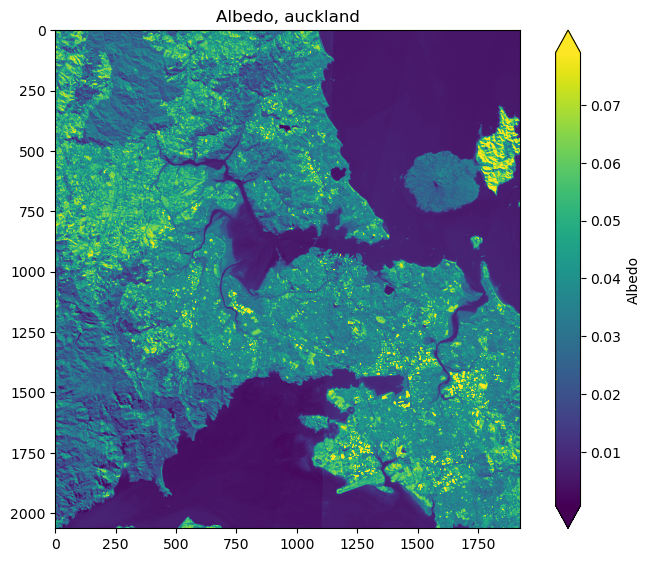

In [4]:
# Figure extent
plt.figure(figsize = (20,22))

# Plotting Albedo data
plt.subplot(3,2,1)
plt.imshow(np.transpose(Albedo))
plt.title("Albedo, "+city)
# colorbar
plt.colorbar(label = "Albedo", extend = "both")
plt.clim(np.nanmin(Albedo),np.nanpercentile(Albedo, 99))
# x-labels
xticks = [int(len(lon)/6)*i for i in np.arange(0,7,1)]
xticklabels = lon[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat)/6)*i for i in np.arange(0,7,1)]
yticklabels = lat[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")

# Plotting LST data
plt.subplot(3,2,2)
plt.imshow(np.transpose(LST), cmap = "YlOrRd")
plt.title("Land Surface Temperature, "+city)
# colorbar
plt.colorbar(label = "LST", extend = "both")
plt.clim(np.nanmin(LST),np.nanpercentile(LST, 99))
# x-labels
xticks = [int(len(lon)/6)*i for i in np.arange(0,7,1)]
xticklabels = lon[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat)/6)*i for i in np.arange(0,7,1)]
yticklabels = lat[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")

# Plotting NDVI data
plt.subplot(3,2,3)
plt.imshow(np.transpose(NDVI), cmap = "YlGn")
plt.title("Normalized Difference Vegetation Index, "+city)
# colorbar
plt.colorbar(label = "NDVI", extend = "both")
plt.clim(np.nanpercentile(NDVI,0.5),np.nanpercentile(NDVI, 99))
# x-labels
xticks = [int(len(lon)/6)*i for i in np.arange(0,7,1)]
xticklabels = lon[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat)/6)*i for i in np.arange(0,7,1)]
yticklabels = lat[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")

# Plotting NDBI data
plt.subplot(3,2,4)
plt.imshow(np.transpose(NDBI), cmap = "Greys")
plt.title("Normalized Difference Built-up Index, "+city)
# colorbar
plt.colorbar(label = "NDBI", extend = "both")
plt.clim(np.nanpercentile(NDBI,0.5),np.nanpercentile(NDBI, 99))
# x-labels
xticks = [int(len(lon)/6)*i for i in np.arange(0,7,1)]
xticklabels = lon[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat)/6)*i for i in np.arange(0,7,1)]
yticklabels = lat[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")

# Plotting NDWI data
plt.subplot(3,2,5)
plt.imshow(np.transpose(NDWI), cmap = "Blues")
plt.title("Normalized Difference Water Index, "+city)
# colorbar
plt.colorbar(label = "NDWI", extend = "both")
plt.clim(np.nanpercentile(NDWI,0.5),np.nanpercentile(NDWI, 99))
# x-labels
xticks = [int(len(lon)/6)*i for i in np.arange(0,7,1)]
xticklabels = lon[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat)/6)*i for i in np.arange(0,7,1)]
yticklabels = lat[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")